In [1]:
import requests
from bs4 import BeautifulSoup as bs

url = 'https://www.smogon.com/dex/sm/formats/uber/'
data = requests.get(url)

In [8]:
html = bs(data.text, 'html.parser')
articles = html.select('head')
tag = articles[0].contents[-2]

In [9]:
import re
start_json_index = re.search('{', str(tag)).start()
end_json_index = [x.start() for x in re.finditer('}', str(tag))][-1]

In [7]:
import json
json_str = str(tag)[start_json_index:end_json_index+1]
json_obj = json.loads(json_str)

In [10]:
import pandas as pd
# pokemon_dataset = pd.DataFrame(json_obj['injectRpcs'][1][1]['pokemon'])
# pokemon_dataset.to_pickle('pokemon_dataset_raw.pkl')
pokemon_dataset = pd.read_pickle('pokemon_dataset_raw.pkl')

In [11]:
gen_map = {
    'RB' : 1,
    'GS' : 2,
    'RS' : 3,
    'DP' : 4,
    'BW' : 5,
    'XY' : 6,
    'SM' : 7,
    'SS' : 8,
    'SV' : 9,
}

pokemon_dataset['gen_introduced'] = [gen['genfamily'][0] if gen else 'NA' for gen in pokemon_dataset['oob']]
pokemon_dataset['gen_introduced'] = pokemon_dataset['gen_introduced'].map(gen_map)

In [78]:
pokemon_dataset['type1'] = [types[0] for types in pokemon_dataset['types']]
pokemon_dataset['type2'] = [types[1] if len(types) > 1 else None for types in pokemon_dataset['types']]
pokemon_dataset['tier'] = [formats[0] if len(formats) > 0 else None for formats in pokemon_dataset['formats']]
## Assumption of using only first ability for modelling
pokemon_dataset['first_ability'] = [formats[0] if len(formats) > 0 else None for formats in pokemon_dataset['abilities']]

In [225]:
dataset = pokemon_dataset[['name',
                           'hp',
                           'atk',
                           'def',
                           'spa',
                           'spd',
                           'spe',
                           'gen_introduced',
                           # 'type1',
                           # 'first_ability',
                        #    'type2',
                           'tier']]
dataset.set_index('name', inplace=True)

In [238]:
# Reassigning similar tiers
dataset_filtered = dataset.copy()
dataset_filtered.dropna(inplace=True)
# BL = borderline tiers, assigning these into a specific tier
dataset_filtered['tier'] = [x[:2] if x[-2:] == 'BL' else x for x in dataset_filtered['tier']]
# too niche/not real tiers being removed
# dataset_filtered = dataset_filtered[~dataset_filtered['tier'].isin(['LC', 'CAP', 'NFE', 'AG'])]
                                    
# dataset_filtered.loc[dataset_filtered['tier'] == 'OU', 'tier'] = 'Uber'
# dataset_filtered.loc[dataset_filtered['tier'] == 'RU', 'tier'] = 'UU'
# dataset_filtered.loc[dataset_filtered['tier'] == 'PU', 'tier'] = 'NU'
# dataset_filtered.loc[dataset_filtered['tier'] == 'Untiered', 'tier'] = 'NU'

dataset_filtered.loc[dataset_filtered['tier']=='Uber', 'tier'] = 'OU'
dataset_filtered.loc[dataset_filtered['tier']!='OU', 'tier'] = 'UU'


# dataset_filtered['type1'] = dataset_filtered['type1'].astype('category').cat.codes
# dataset_filtered['type2'] = dataset_filtered['type2'].astype('category').cat.codes
# dataset_filtered['first_ability'] = dataset_filtered['first_ability'].astype('category').cat.codes

In [241]:
from sklearn.model_selection import train_test_split
X = dataset_filtered.copy()
y = X.pop('tier')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1702)

In [258]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(max_depth=25, n_estimators=2000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

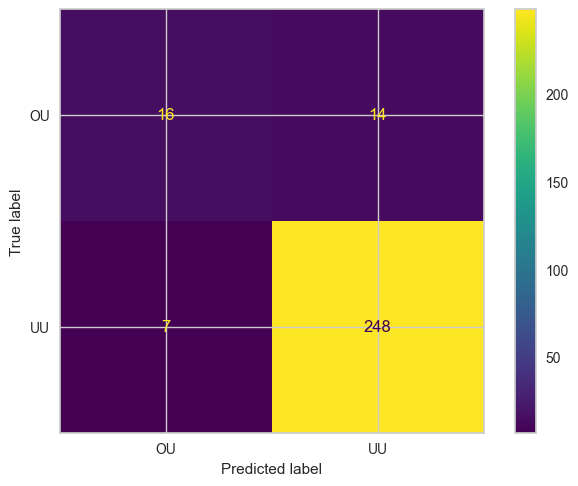

In [259]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = y_test.copy()
y_pred = preds
cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

In [213]:
df_test = pd.DataFrame(X_test)
df_test['actual'] = y_test
df_test['prediction'] = y_pred
df_test

,hp,atk,def,spa,spd,spe,gen_introduced,type1,actual,prediction
name,,,,,,,,,,
Exeggutor-Alola,95,105,85,125,75,45,7.0,9,NU,NU
Marowak-Alola,60,80,110,50,80,45,7.0,6,UU,NU
Marowak-Alola-Totem,60,80,110,50,80,45,7.0,6,UU,NU
Raticate-Alola,75,71,70,40,80,77,7.0,1,NU,NU
Raticate-Alola-Totem,75,71,70,40,80,77,7.0,1,NU,NU
...,...,...,...,...,...,...,...,...,...,...
Naganadel,73,73,73,127,73,121,7.0,13,Uber,UU
Stakataka,61,131,211,53,101,13,7.0,15,UU,NU
Blacephalon,53,127,53,151,79,107,7.0,6,Uber,UU


In [214]:
df_test[df_test['prediction'] == 'Uber']

,hp,atk,def,spa,spd,spe,gen_introduced,type1,actual,prediction
name,,,,,,,,,,
Arceus-Fairy,120,120,120,120,120,120,6.0,4,Uber,Uber
Hydreigon,92,105,90,125,90,98,5.0,1,UU,Uber
Reshiram,100,120,100,150,120,90,5.0,2,Uber,Uber
Zekrom,100,150,120,120,100,90,5.0,2,Uber,Uber
Kyurem,125,130,90,130,90,95,5.0,2,UU,Uber
Kyurem-Black,125,170,100,120,90,95,5.0,2,Uber,Uber
Kyurem-White,125,120,90,170,100,95,5.0,2,Uber,Uber
Genesect,71,120,95,120,95,99,5.0,0,Uber,Uber
Genesect-Burn,71,120,95,120,95,99,5.0,0,Uber,Uber


KNN

In [269]:
from sklearn.neighbors import KNeighborsClassifier
X = pokemon_dataset.copy()
features = ['hp', 'atk', 'def', 'spa', 'spd', 'spe']
y = X['name']
X = X[features]
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [275]:
neigh.predict([[70,40,65,100,65,95]])

C:\Users\Jacque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['Lilligant'], dtype=object)

In [298]:
l = neigh.kneighbors([[100,100,100,100,100,100]], n_neighbors=10, return_distance=False)

C:\Users\Jacque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [299]:
pokemon_dataset.iloc[l.ravel()]

,name,hp,atk,def,spa,spd,spe,weight,height,types,abilities,formats,isNonstandard,oob,gen_introduced,type1,type2,tier,first_ability
244,Celebi,100,100,100,100,100,100,5.0,0.6,"[Psychic, Grass]",[Natural Cure],[UU],Standard,"{'dex_number': 251, 'evos': [], 'alts': [], 'g...",2.0,Psychic,Grass,UU,Natural Cure
527,Shaymin,100,100,100,100,100,100,2.1,0.2,[Grass],[Natural Cure],[RU],Standard,"{'dex_number': 492, 'evos': [], 'alts': [], 'g...",4.0,Grass,None,RU,Natural Cure
397,Jirachi,100,100,100,100,100,100,1.1,0.3,"[Steel, Psychic]",[Serene Grace],[OU],Standard,"{'dex_number': 385, 'evos': [], 'alts': [], 'g...",3.0,Steel,Psychic,OU,Serene Grace
547,Victini,100,100,100,100,100,100,4.0,0.4,"[Psychic, Fire]",[Victory Star],[OU],Standard,"{'dex_number': 494, 'evos': [], 'alts': [], 'g...",5.0,Psychic,Fire,OU,Victory Star
122,Mew,100,100,100,100,100,100,4.0,0.4,[Psychic],[Synchronize],[UU],Standard,"{'dex_number': 151, 'evos': [], 'alts': [], 'g...",1.0,Psychic,None,UU,Synchronize
525,Manaphy,100,100,100,100,100,100,1.4,0.3,[Water],[Hydration],[OU],Standard,"{'dex_number': 490, 'evos': [], 'alts': [], 'g...",4.0,Water,None,OU,Hydration
904,Silvally-Fighting,95,95,95,95,95,95,100.5,2.3,[Fighting],[RKS System],[Untiered],Standard,"{'dex_number': 773, 'evos': [], 'alts': [], 'g...",7.0,Fighting,None,Untiered,RKS System
909,Silvally-Ground,95,95,95,95,95,95,100.5,2.3,[Ground],[RKS System],[Untiered],Standard,"{'dex_number': 773, 'evos': [], 'alts': [], 'g...",7.0,Ground,None,Untiered,RKS System
908,Silvally-Grass,95,95,95,95,95,95,100.5,2.3,[Grass],[RKS System],[Untiered],Standard,"{'dex_number': 773, 'evos': [], 'alts': [], 'g...",7.0,Grass,None,Untiered,RKS System
907,Silvally-Ghost,95,95,95,95,95,95,100.5,2.3,[Ghost],[RKS System],[PU],Standard,"{'dex_number': 773, 'evos': [], 'alts': [], 'g...",7.0,Ghost,None,PU,RKS System


In [273]:
pokemon_dataset[pokemon_dataset['name'] == 'Lilligant']

,name,hp,atk,def,spa,spd,spe,weight,height,types,abilities,formats,isNonstandard,oob,gen_introduced,type1,type2,tier,first_ability
612,Lilligant,70,60,75,110,75,90,16.3,1.1,[Grass],"[Chlorophyll, Own Tempo, Leaf Guard]",[PUBL],Standard,"{'dex_number': 549, 'evos': [], 'alts': [], 'g...",5.0,Grass,None,PUBL,Chlorophyll
